<a href="https://colab.research.google.com/github/karljackson1988/Land-Registry-Transactions/blob/main/Land_Registry_Transactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

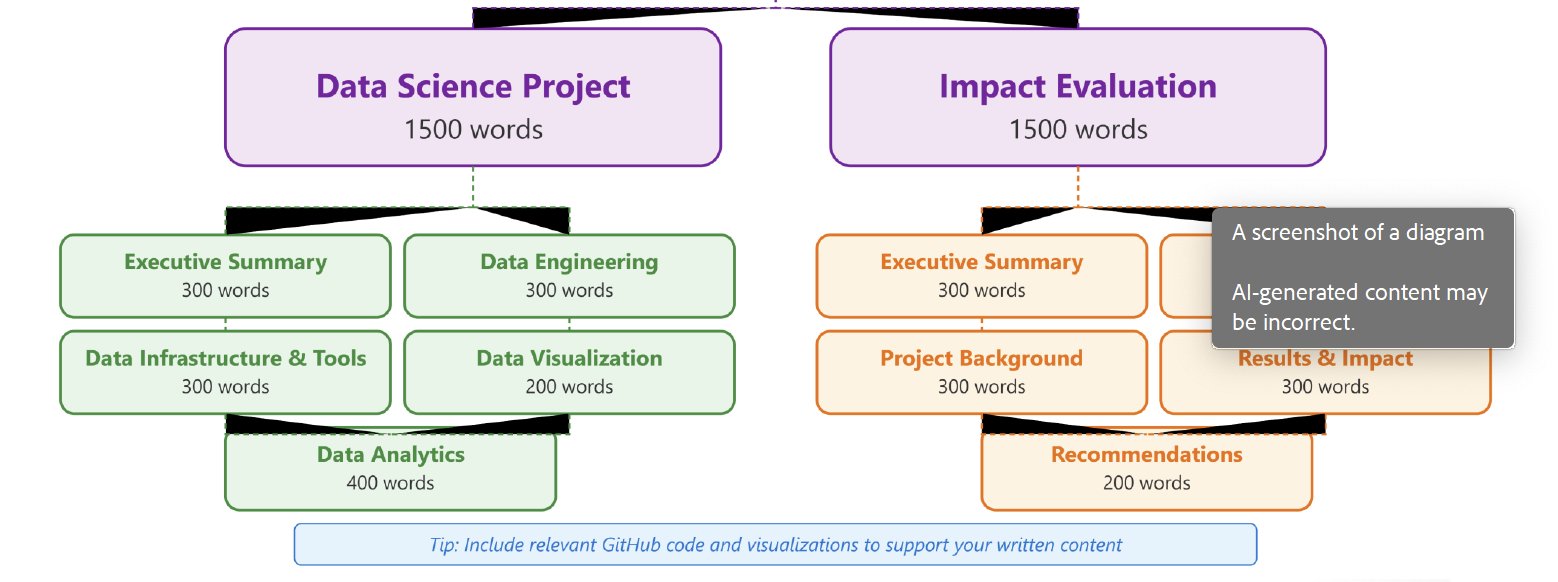

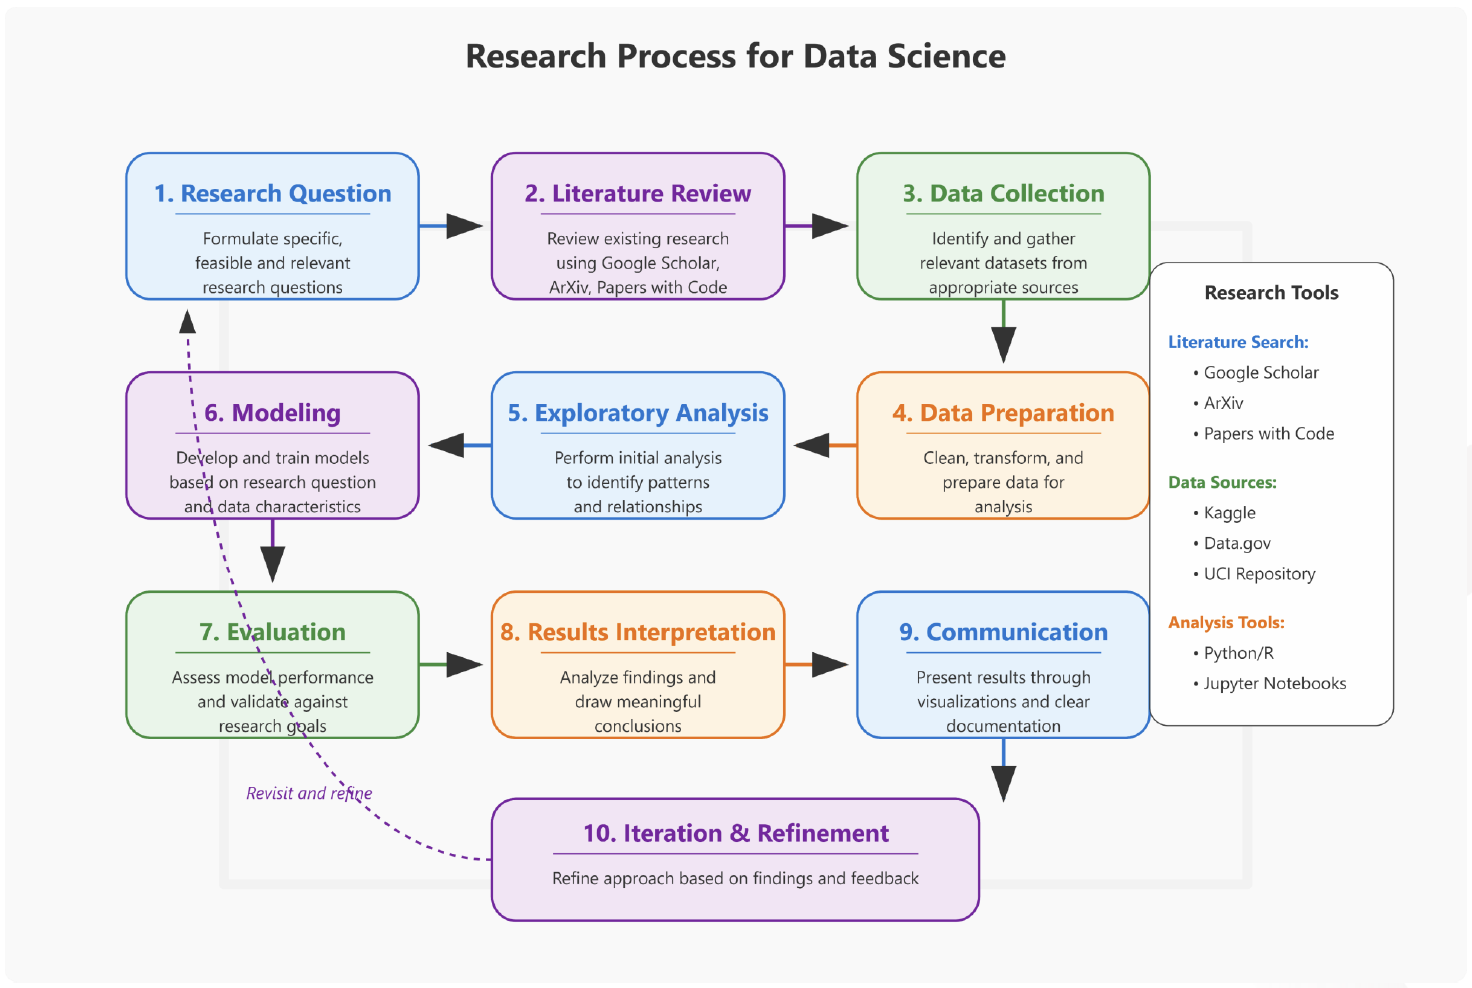

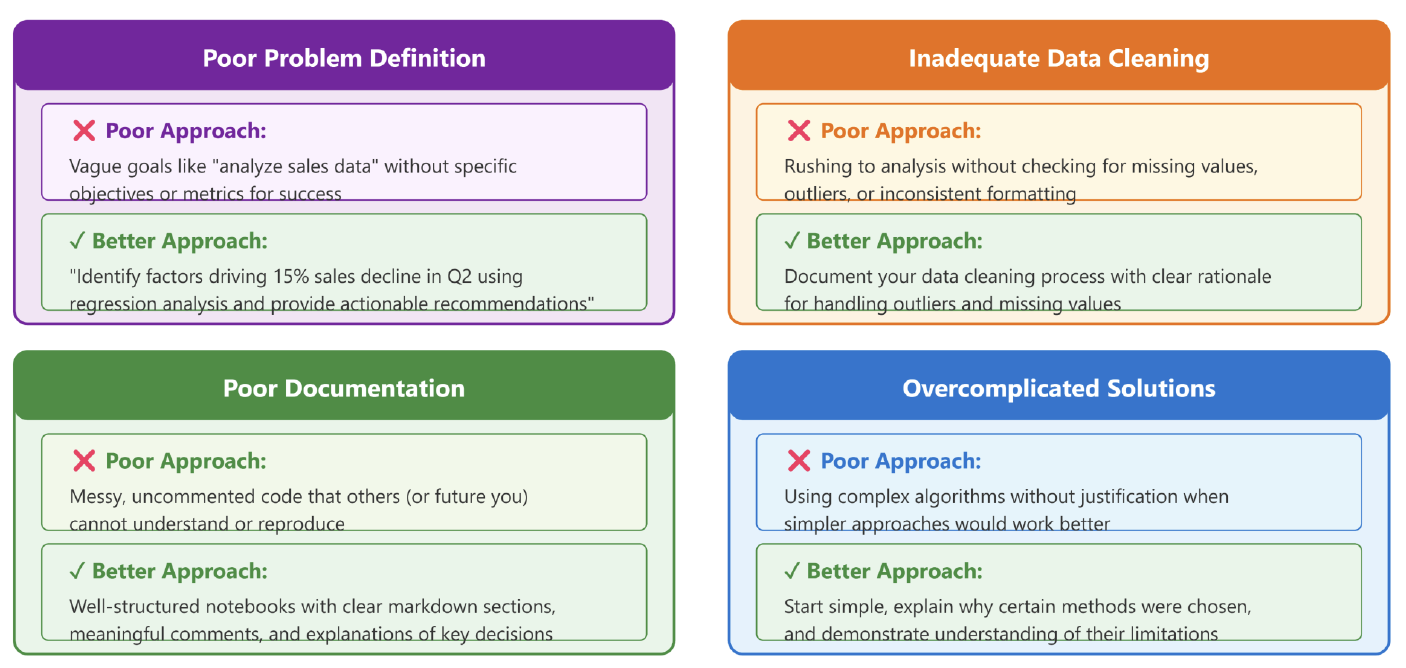

#**Land Registry Transactions:** Spatial & Temporal Analysis Using K-Means Clustering

##**Project Background**

The objective of this project is to explore and uncover patterns in UK property transactions over time and across regions. By analysing a large dataset of Land Registry transactions, the project aims to reveal insights into price dynamics, geographical disparities, and the extent to which different areas of the country behave as distinct “micro-markets.” Understanding these patterns can give people a clearer picture of how the property market is shifting. Whether it’s first-time buyers trying to get on the ladder, homeowners deciding when to move, or small developers and investors who need to balance risk and return, having access to this kind of analysis helps them spot opportunities, avoid overpriced areas, and make decisions grounded in actual market behaviour rather than headlines.

From a data-science perspective, the project combines data engineering (ETL using Python and pandas) with exploratory data analysis (EDA) and an unsupervised learning step. The unsupervised piece uses K-Means clustering to group postcode areas that share similar price and activity characteristics. The result is an interpretable segmentation of the UK property landscape that complements traditional metrics like average price or sales volume.




---



##**Data Description**
The dataset is sourced from the UK Land Registry Price Paid records and spans 2008–2025, comprising tens of millions of rows. Each record represents a single property transaction and includes, among other fields:
•	Price paid (GBP)
•	Date of transfer
•	Property type (Detached, Semi-Detached, Terraced, Flat/Maisonette, Other)
•	Tenure (Freehold/Leasehold)
•	Address components (PAON/SAON, Street, Locality, Town/City, District, County, Postcode)
•	Record status / category flags
Data was ingested directly from the Land Registry’s public data service (hosted on GOV.UK/AWS). Files were loaded with pandas.read_csv and appended into a single DataFrame before being written to Parquet, which gives a much smaller on-disk footprint and dramatically faster reloads for iterative analysis.



---


#**Key Questions Explored**

•	How have average property prices changed over time?
We summarise nominal prices monthly/annually and look for structural shifts (e.g., post-2016, pandemic period, recent rate rises).

•	Which property types have appreciated the most?
Splitting the time series by Detached/Semi/ Terrace/Flat reveals different cycles and sensitivities.

•	Are there postcode regions with consistently high or low prices?
Aggregations at outward postcode (e.g., SW, L, B) and sector level show broad regional bands.

•	Can regional clusters be identified using machine learning?
K-Means segments areas with similar price levels and sales activity to surface “market tiers.”

Tools & Technologies
•	Python: ETL, analysis, visualization
•	Pandas: Data processing
•	Seaborn/Matplotlib: Visual exploration
•	Scikit-learn: K-Means clustering
•	Parquet: Optimized data storage format


import relevant libraries.

Define relevant date periods.

Declare location to gather data from.

Create an empty dataframe.

In [ ]:
import pandas as pd

start = 2015
end = 2026

years = range(start, end)
base_url = "http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-{}.txt"

# Empty list to collect each year's DataFrame
all_data = []

run loop to extract data for defined date periods.

In [ ]:
for year in years:
    url = base_url.format(year)
    try:
        df = pd.read_csv(url, sep=',', header=None, dtype=str)
        df['Year'] = year
        all_data.append(df)
        print(f"Loaded data for {year}")
    except Exception as e:
        print(f"Failed to load data for {year}: {e}")



Loaded data for 2015
Loaded data for 2016
Loaded data for 2017
Loaded data for 2018
Loaded data for 2019
Loaded data for 2020
Loaded data for 2021
Loaded data for 2022
Loaded data for 2023
Loaded data for 2024
Loaded data for 2025


Append / Concatenate all yealry data files into a single dataframe.

In [ ]:
# Combine all into one DataFrame
full_data = pd.concat(all_data, ignore_index=True)

In [ ]:
#full_data

Specify the columnular naming convention.

In [ ]:
columns = [
    "Transaction unique identifier", "Price", "Date of Transfer", "Postcode",
    "Property Type", "Old/New", "Duration", "PAON", "SAON",
    "Street", "Locality", "Town/City", "District", "County",
    "PPD Category Type", "Record Status"
]

Add the data year as a column data point.

In [ ]:
full_data.columns = columns + ["Year"]

Check for missing values by column

In [ ]:

missing_values = full_data.isnull().sum()
missing_percent = (missing_values / len(full_data)) * 100
missing_summary = pd.DataFrame({
    "Missing Values": missing_values,
    "Percent Missing": missing_percent
})
print("Missing Data Summary:\n", missing_summary.sort_values(by="Percent Missing", ascending=False))


Missing Data Summary:
                                Missing Values  Percent Missing
SAON                                  8869079        86.380307
Locality                              6394248        62.276715
Street                                 183008         1.782405
Postcode                                35339         0.344184
Transaction unique identifier               0         0.000000
Property Type                               0         0.000000
Old/New                                     0         0.000000
Date of Transfer                            0         0.000000
Price                                       0         0.000000
PAON                                        0         0.000000
Duration                                    0         0.000000
Town/City                                   0         0.000000
District                                    0         0.000000
County                                      0         0.000000
PPD Category Type               

SAON (Secondary Addressable Object Name): This field typically includes details like apartment numbers or suites. With over 86% missing, it is likely only applicable to a subset of urban addresses. Its removal was deemed appropriate to avoid skewing downstream analysis.



---



Locality: Although this field can provide additional context to the address, over 60% is missing and it often overlaps with more complete fields like Town/City, District, and Postcode. Therefore, it was excluded to streamline the dataset.

Street, PAON, Postcode: These fields had very low levels of missingness and were retained for their importance in geospatial or property-specific analyses.

In [ ]:
# Drop high-missing-value columns
full_data = full_data.drop(columns=["SAON", "Locality"])

Extract the first [n] characters for the postcode area based on example:

Formatting
Overview
The postcodes are alphanumeric, and are (possibly uniquely) variable in length: ranging from six to eight characters (including a space). Each postcode is divided into two parts separated by a single space: the outward code and the inward code respectively. The outward code includes the postcode area and the postcode district, respectively. The inward code includes the postcode sector and the postcode unit respectively. Examples of postcodes are "SW1W 0NY", "PO16 7GZ", "GU16 7HF", and "L1 8JQ".

POSTCODE:        SW1W 0NY

Outward code:    SW

Inward code:     1W

Area	District:  0

Sector	Unit:    NY


In [ ]:
full_data["Postcode_Area"] = full_data["Postcode"].str.extract(r'^(\S+)')

Ensure the "Price" is stored as an integer

In [ ]:
full_data["Price"] = pd.to_numeric(full_data["Price"], errors="coerce")

In [ ]:
# Keep only residential, valid, private sales
full_data = full_data[
    (full_data['PPD Category Type'] == 'A') &
    (full_data['Price'] < 10000000) &
    (full_data['Price'] > 1_000)
]


In [ ]:
full_data.columns

Index(['Transaction unique identifier', 'Price', 'Date of Transfer',
       'Postcode', 'Property Type', 'Old/New', 'Duration', 'PAON', 'Street',
       'Town/City', 'District', 'County', 'PPD Category Type', 'Record Status',
       'Year', 'Postcode_Area'],
      dtype='object')

In [ ]:
# Distinct counts
print("Distinct Record Status:", full_data["Record Status"].nunique())
print("Distinct Town/City:", full_data["Town/City"].nunique())
print("Distinct Districts:", full_data["District"].nunique())
print("Distinct Counties:", full_data["County"].nunique())

Distinct Record Status: 1
Distinct Town/City: 1152
Distinct Districts: 361
Distinct Counties: 117


In [ ]:
#full_data.to_parquet("land_registry_data_2005_2025.parquet", index=False)

In [ ]:
import random

# Drop NaNs first to avoid errors
valid_postcodes = full_data["Postcode"].dropna().unique()

# Randomly pick one postcode
random_postcode = random.choice(valid_postcodes)

# Filter the dataset for that postcode
postcode_area = full_data[full_data["Postcode"] == random_postcode]

print(f"Randomly selected postcode: {random_postcode}")



Randomly selected postcode: RH12 4SA


In [ ]:
postcode_area

,Transaction unique identifier,Price,Date of Transfer,Postcode,Property Type,Old/New,Duration,PAON,Street,Town/City,District,County,PPD Category Type,Record Status,Year,Postcode_Area
6259001,{EA3278AA-BEEB-2676-E053-6B04A8C015F8},557500,2021-06-29 00:00,RH12 4SA,D,N,F,FROGMORE,CRAWLEY ROAD,HORSHAM,HORSHAM,WEST SUSSEX,A,A,2021,RH12


In [ ]:
full_data.columns

Index(['Transaction unique identifier', 'Price', 'Date of Transfer',
       'Postcode', 'Property Type', 'Old/New', 'Duration', 'PAON', 'Street',
       'Town/City', 'District', 'County', 'PPD Category Type', 'Record Status',
       'Year', 'Postcode_Area'],
      dtype='object')

In [ ]:
# Distinct counts
print("Distinct Town/City:", full_data["Town/City"].nunique())
print("Distinct Districts:", full_data["District"].nunique())
print("Distinct Counties:", full_data["County"].nunique())

Distinct Town/City: 1152
Distinct Districts: 361
Distinct Counties: 117


In [ ]:
# Group by Year and Town/City, then calculate average Price
avg_price_city_year = full_data.groupby(['Year', 'Town/City', 'Postcode'])['Price'].mean().reset_index()

# Optionally sort to make it easier to view
avg_price_city_year = avg_price_city_year.sort_values(by=['Year', 'Price'], ascending=[True, False])

# Preview the first few rows
pd.set_option('display.float_format', '{:,.0f}'.format)
print(avg_price_city_year)


         Year   Town/City  Postcode     Price
262436   2015      LONDON  SW14 7EW 9,500,000
266684   2015      LONDON   SW3 6EY 9,500,000
265733   2015      LONDON  SW1W 9JJ 9,200,000
265768   2015      LONDON  SW1X 7AF 9,200,000
266681   2015      LONDON   SW3 6BP 9,200,000
...       ...         ...       ...       ...
4820591  2025  BIRMINGHAM   B32 3JA    10,950
4877461  2025       LEEDS   LS1 2EX    10,557
4820086  2025  BIRMINGHAM   B26 3LE    10,000
4884401  2025   LIVERPOOL    L9 9DQ    10,000
4940704  2025     STANLEY   DH9 7HA    10,000

[4967114 rows x 4 columns]


In [ ]:
#district_area = district_area[district_area["Town/City"] == "NESTON"]#.sort_values(by='Price', ascending=True)

# Sort by price (ascending)
#Town = Town.sort_values(by='Price', ascending=True)


#district_area

In [ ]:
# Filter out single-sale towns per year to avoid skew
transaction_counts = full_data.groupby(['Year', 'Town/City', 'Postcode'])['Price'].count().reset_index(name='n_sales')
merged = avg_price_city_year.merge(transaction_counts, on=['Year', 'Town/City', 'Postcode'])
filtered_avg = merged[merged['n_sales'] > 0]  # Keep only those with more than 1 transaction

# Now use `filtered_avg` for charts or summaries
filtered_avg

,Year,Town/City,Postcode,Price,n_sales
0,2015,LONDON,SW14 7EW,"9,500,000",1
1,2015,LONDON,SW3 6EY,"9,500,000",1
2,2015,LONDON,SW1W 9JJ,"9,200,000",1
3,2015,LONDON,SW1X 7AF,"9,200,000",1
4,2015,LONDON,SW3 6BP,"9,200,000",1
...,...,...,...,...,...
4967109,2025,BIRMINGHAM,B32 3JA,"10,950",1
4967110,2025,LEEDS,LS1 2EX,"10,557",1
4967111,2025,BIRMINGHAM,B26 3LE,"10,000",1
4967112,2025,LIVERPOOL,L9 9DQ,"10,000",1


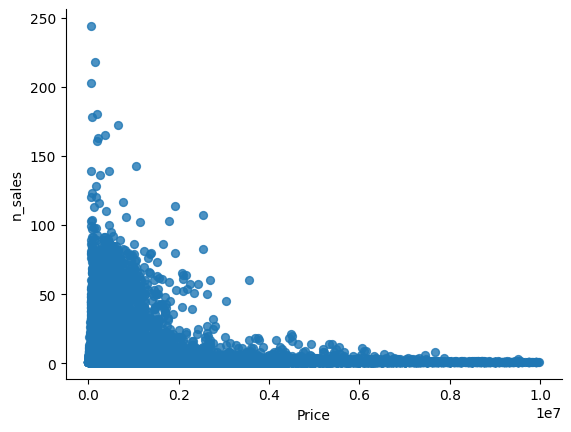

In [ ]:
from matplotlib import pyplot as plt
filtered_avg.plot(kind='scatter', x='Price', y='n_sales', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

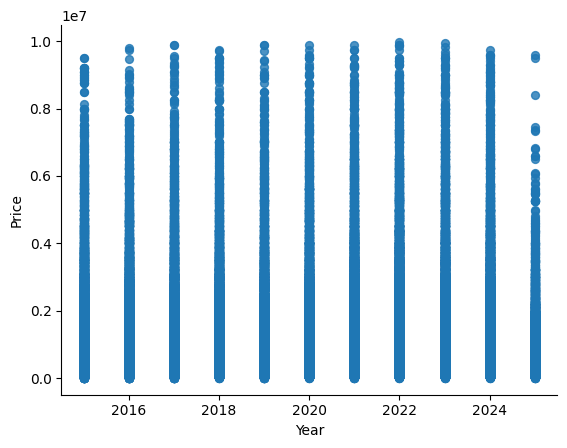

In [ ]:
from matplotlib import pyplot as plt
filtered_avg.plot(kind='scatter', x='Year', y='Price', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

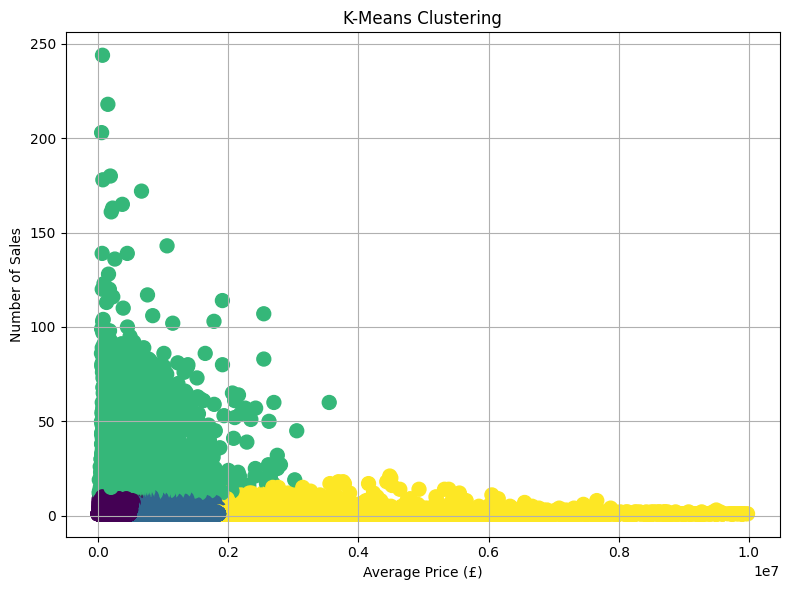

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

summary = filtered_avg.copy()

# Select features
features = summary[['Price', 'n_sales']].copy()

# Scale the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Run K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
summary['Cluster'] = kmeans.fit_predict(scaled_features)

# Visualize
plt.figure(figsize=(8, 6))
plt.scatter(summary['Price'], summary['n_sales'],
            c=summary['Cluster'], cmap='viridis', s=100)
plt.xlabel('Average Price (£)')
plt.ylabel('Number of Sales')
plt.title('K-Means Clustering')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans

# Encode Postcode_Area for internal use (not recommended for distance calc)
data = filtered_avg.copy()
data['Postcode_Code'] = LabelEncoder().fit_transform(data['Postcode'])

# Use Year, Price, n_sales
X = data[['Year', 'Price', 'n_sales']].copy()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
data['Cluster'] = kmeans.fit_predict(X_scaled)


In [ ]:
data

,Year,Town/City,Postcode,Price,n_sales,Postcode_Code,Cluster
0,2015,LONDON,SW14 7EW,"9,500,000",1,955457,1
1,2015,LONDON,SW3 6EY,"9,500,000",1,963571,1
2,2015,LONDON,SW1W 9JJ,"9,200,000",1,961575,1
3,2015,LONDON,SW1X 7AF,"9,200,000",1,961648,1
4,2015,LONDON,SW3 6BP,"9,200,000",1,963556,1
...,...,...,...,...,...,...,...
4967109,2025,BIRMINGHAM,B32 3JA,"10,950",1,15222,3
4967110,2025,LEEDS,LS1 2EX,"10,557",1,517855,3
4967111,2025,BIRMINGHAM,B26 3LE,"10,000",1,11840,3
4967112,2025,LIVERPOOL,L9 9DQ,"10,000",1,469454,3


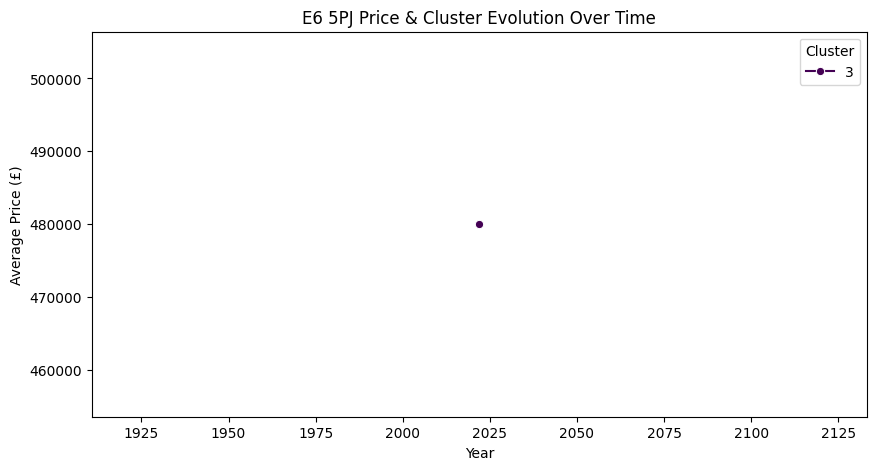

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop NaNs first to avoid errors
valid_postcodes = full_data["Postcode"].dropna().unique()

# Randomly pick one postcode
random_postcode = random.choice(valid_postcodes)

area_history = data[data['Postcode'] == random_postcode]
#area_history = data[data['Postcode'] == "CH62 5EG"]

plt.figure(figsize=(10, 5))
sns.lineplot(x='Year', y='Price', hue='Cluster', data=area_history, palette='viridis', marker='o')
plt.title(f"{random_postcode} Price & Cluster Evolution Over Time")
plt.ylabel("Average Price (£)")
plt.show()


In [ ]:
area_history

,Year,Town/City,Postcode,Price,n_sales,Postcode_Code,Cluster
3561300,2022,LONDON,E6 5PJ,"480,000",1,319094,3


#Most Desired Place to Live
Based on cumulative number of sales over time.

In [ ]:
# Group by Postcode and sum all sales
most_desired = data.groupby('Postcode')['n_sales'].sum().reset_index()
most_desired = most_desired.sort_values(by='n_sales', ascending=False)

print("Top 10 most desired postcodes:\n", most_desired.head(10))


Top 10 most desired postcodes:
         Postcode  n_sales
533765   LU1 5FT      295
557451    M5 3WH      288
462160    L3 8HA      257
147015  CF10 3FH      251
954493  SW11 7AY      235
467905    L5 3AA      213
538310    M1 5GB      207
313108   E14 9GU      204
935370   SS2 6EB      203
778204  RG21 7AA      197


#Most Prestigious Place to Live
Based on average price over time (not just one expensive sale).

In [ ]:
# Group by Postcode and take average price
prestigious = data.groupby('Postcode')['Price'].mean().reset_index()
prestigious = prestigious.sort_values(by='Price', ascending=False)

print("Top 10 most prestigious postcodes:\n", prestigious.head(10))


Top 10 most prestigious postcodes:
          Postcode     Price
965723    SW7 2TE 9,900,000
965772    SW7 3LZ 9,800,000
372469   GU25 4NL 9,750,000
1057589    W9 1AA 9,750,000
687777    NW8 9BQ 9,730,000
913029   SO24 9TW 9,600,998
687464    NW8 6AP 9,500,000
960999   SW1P 3RX 9,500,000
1050573   W11 2LE 9,500,000
687822    NW8 9JP 9,500,000


In [ ]:
prestigious_search = full_data[full_data["Postcode"] == "SE1 9AN"]
prestigious_search

,Transaction unique identifier,Price,Date of Transfer,Postcode,Property Type,Old/New,Duration,PAON,Street,Town/City,District,County,PPD Category Type,Record Status,Year,Postcode_Area


#Areas With Highest Price Growth
Postcodes where price increased the most between first and last year (with at least 2 sales in each year).

In [ ]:
# Ensure we only use postcode-years with at least 2 sales
multi_sales = data[data['n_sales'] >= 2]

# Find min and max year per postcode
yearly_price = multi_sales.groupby(['Postcode', 'Year'])['Price'].mean().reset_index()

# Compute first and last price per postcode
first_last = yearly_price.groupby('Postcode').agg(
    first_year=('Year', 'min'),
    last_year=('Year', 'max')
).reset_index()

# Merge back to get actual prices
first_price = yearly_price.merge(first_last[['Postcode', 'first_year']],
                                 left_on=['Postcode', 'Year'],
                                 right_on=['Postcode', 'first_year'])

last_price = yearly_price.merge(first_last[['Postcode', 'last_year']],
                                left_on=['Postcode', 'Year'],
                                right_on=['Postcode', 'last_year'])

# Combine first and last prices
growth = first_price[['Postcode', 'Price']].merge(
    last_price[['Postcode', 'Price']], on='Postcode', suffixes=('_start', '_end')
)
growth['price_growth'] = growth['Price_end'] - growth['Price_start']
growth = growth.sort_values(by='price_growth', ascending=False)

print("Top 10 growing postcodes:\n", growth.head(10))


Top 10 growing postcodes:
         Postcode  Price_start  Price_end  price_growth
650865    W9 1AN    1,550,500  9,560,500     8,010,000
650658    W8 4SA    3,008,333  9,075,000     6,066,667
279802   KT2 7DY    3,450,000  9,500,000     6,050,000
592078  SW13 9RT    3,235,000  9,276,000     6,041,000
597473   SW3 4XA    1,625,000  7,437,500     5,812,500
650829    W8 7NA      515,000  6,188,333     5,673,333
425704   NW8 0PL      902,500  6,575,000     5,672,500
592026  SW13 9EX      525,000  6,050,000     5,525,000
612777  TN11 8HY    1,237,500  6,750,000     5,512,500
650655    W8 4RR    1,312,500  6,816,667     5,504,167
